## Script to sample from pretrained riff-cnet model

Requires GPU. Best to Run in Google Colab. Just clone the entire github into your drive and pull the model from HuggingFace as directed below to make this work. Make sure you have set up the control condas environment as well.

In [1]:
# # UNCOMMENT AND RUN THIS BLOCK IF USING GOOGLE COLAB

# from google.colab import drive
# drive.mount("/content/drive/")

# ## cd into desired directory 
# %cd drive/MyDrive/<my-directory>
# %ls

# # pull git repo 
# # get training data
# !git clone https://github.com/zachary-shah/riff-cnet.git
# %cd riff-cnet

# # even with the environment set up, you may need to install some other dependencies (run only if you get errors below)
# !pip install Pillow==9.4.0
# !pip install einops
# !pip install omegaconf
# !pip install pytorch_lightning
# !pip install transformers
# !pip install open-clip-torch
# !pip install pydub

In [ ]:
# load model from huggingface
!git lfs install
!git clone https://huggingface.co/zachary-shah/riffusion-cnet-v2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
import einops 
from pytorch_lightning import seed_everything
import cv2
import os
from PIL import Image
import numpy as np
import random 

from riffusion.spectrogram_image_converter import SpectrogramImageConverter
from riffusion.spectrogram_converter import SpectrogramConverter
from riffusion.spectrogram_params import SpectrogramParams

from cldm.ddim_hacked import DDIMSampler
from cnet_riff_dataset import CnetRiffDataset
from cldm.model import create_model, load_state_dict

In [ ]:
# load model into pytorch 
mdl_path = "riffusion-cnet-v2/final_checkpoint.ckpt"
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(mdl_path, location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

In [42]:
# some helper functions needed

# image helper functions
def HWC3(x):
    assert x.dtype == np.uint8
    if x.ndim == 2:
        x = x[:, :, None]
    assert x.ndim == 3
    H, W, C = x.shape
    assert C == 1 or C == 3 or C == 4
    if C == 3:
        return x
    if C == 1:
        return np.concatenate([x, x, x], axis=2)
    if C == 4:
        color = x[:, :, 0:3].astype(np.float32)
        alpha = x[:, :, 3:4].astype(np.float32) / 255.0
        y = color * alpha + 255.0 * (1.0 - alpha)
        y = y.clip(0, 255).astype(np.uint8)
        return y
def resize_image(input_image, resolution):
    H, W, C = input_image.shape
    H = float(H)
    W = float(W)
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(np.round(H / 64.0)) * 64
    W = int(np.round(W / 64.0)) * 64
    img = cv2.resize(input_image, (W, H), interpolation=cv2.INTER_LANCZOS4 if k > 1 else cv2.INTER_AREA)
    return img

# helper function to sample the model
def sample_ddim(control, prompt, model,
                guess_mode = False,
                strength = 1,
                scale = 9,
                eta = 0,
                num_samples = 1,
                ddim_steps = 50,
                seed = -1,
                image_resolution = 512,
                log_every_t=100):

    with torch.no_grad():
        # preprocessing
        control = resize_image(HWC3(control), image_resolution)
        H, W, C = control.shape
        control = torch.from_numpy(control).float().cuda()
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        # to save memory
        model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([""] * num_samples)]}
        shape = (4, H // 8, W // 8)

        # to save memory
        model.low_vram_shift(is_diffusing=True)

        # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  
        
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                        shape, cond, verbose=False, eta=eta,
                                                        unconditional_guidance_scale=scale, log_every_t=log_every_t,
                                                        unconditional_conditioning=un_cond)

        # to save memory
        model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]

        return results, intermediates

In [ ]:
# just get one sample from the dataset, and listen to example sample from cnet-riff
test_dataset = CnetRiffDataset("train-data/")
os.makedirs("samples", exist_ok=True)

i = 0
results, _ = sample_ddim(test_dataset[i]['hint'], test_dataset[i]['txt'], model, num_samples=4)
plt.imshow(results[0])
sample = results[0]

cv2.imwrite("samples/test_sample.png", sample)

img_converter_to_audio = SpectrogramImageConverter(SpectrogramParams(sample_rate=44100, min_frequency=0, max_frequency=10000))

sample_img = Image.open("samples/test_sample.png") 

out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(sample_img, apply_filters=True).set_channels(2)
out_audio_recon.export("test_sample.wav", format="wav")
out_audio_recon

In [ ]:
# now listen to target desired to compare to the sample generated (background is very similar but melody is different!)
target = (test_dataset[i]['jpg'] + 1) / 2 * 255
cv2.imwrite("samples/test_sample_target.png", target)
target_img = Image.open("samples/test_sample_target.png") 

out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(target_img, apply_filters=True).set_channels(2)
out_audio_recon.export("test_sample_target.wav", format="wav")
out_audio_recon

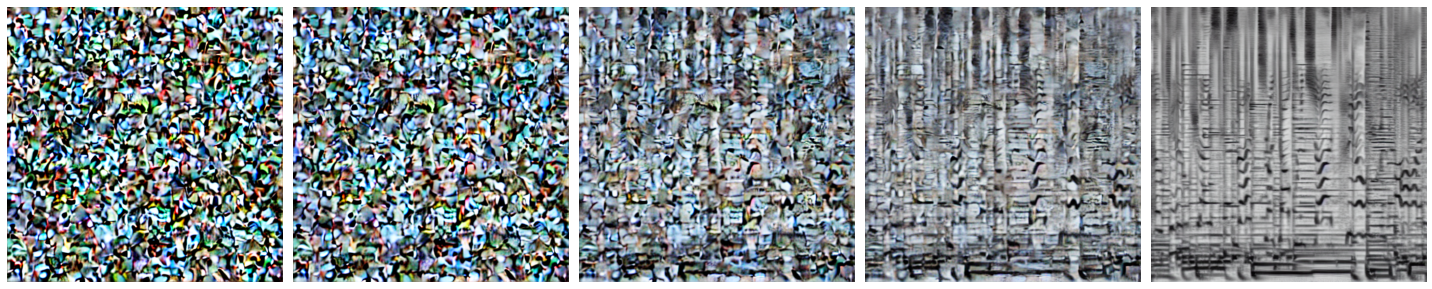

<Figure size 1440x504 with 0 Axes>

In [62]:
## run this block to see an example of the diffusion process at work 

test_dataset = CnetRiffDataset("train-data/")
print(f"Len dataset: {len(test_dataset)}")

os.makedirs("samples", exist_ok=True)
img_converter_to_audio = SpectrogramImageConverter(SpectrogramParams(sample_rate=44100, min_frequency=0, max_frequency=10000))

control = test_dataset[0]['hint']
prompt = test_dataset[0]['txt']
results, intermediates = sample_ddim(control, prompt, model, num_samples=1, log_every_t=5)

print(f"keys: {intermediates.keys()}")

x_inter = intermediates['x_inter']
pred_x0 = intermediates['pred_x0']

print(f"x_inter len: {len(x_inter)}")
print(f"pred_x0 len: {len(pred_x0)}")

x_inter_processed = []
for i in range(len(x_inter)):
  x_step = model.decode_first_stage(x_inter[i])
  x_step = (einops.rearrange(x_step, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
  x_inter_processed.append(x_step.squeeze())

pred_x0_processed = []
for i in range(len(pred_x0)):
  x_step = model.decode_first_stage(pred_x0[i])
  x_step = (einops.rearrange(x_step, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
  pred_x0_processed.append(x_step.squeeze())


import matplotlib.gridspec as gridspec

plt.rcParams["figure.figsize"] = [20, 7]
plt.rcParams["figure.autolayout"] = True
gs1 = gridspec.GridSpec(1, 7)
gs1.update(wspace=0.1, hspace=0.1)

fig = plt.figure(figsize=(20,7))
fig.tight_layout()
inds = [0, 4, 7, 9, 11]
for (i, ind) in enumerate(inds):
  plt.subplot(1,len(inds),i+1)
  plt.imshow(x_inter_processed[ind])
  plt.axis("off")
plt.show()
plt.savefig(f"Diffusion steps {inds}")

In [ ]:
# run this block to get a bunch of samples from the model
test_dataset = CnetRiffDataset("train-data/")
print(f"Len dataset: {len(test_dataset)}")

os.makedirs("samples2", exist_ok=True)
img_converter_to_audio = SpectrogramImageConverter(SpectrogramParams(sample_rate=44100, min_frequency=0, max_frequency=10000))

n_count = 0
for (i,item) in enumerate(test_dataset):
    if "reggae" in item['txt']:
        print(item['txt'])
        results, _ = sample_ddim(item['hint'], item['txt'], model, num_samples=4)

        for (k, sample) in enumerate(results):
            cv2.imwrite(os.path.join("samples2/",f"{item['txt']}_samp_{k}.png"), sample)

            sample_img = Image.open(os.path.join("samples2/",f"{item['txt']}_samp_{k}.png"))
            out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(sample_img, apply_filters=True).set_channels(2)
            out_audio_recon.export(os.path.join("samples2/",f"{item['txt']}_samp_{k}.wav"), format="wav")

        # save target too
        target = (item['jpg'] + 1) / 2 * 255
        cv2.imwrite(os.path.join("samples2/",f"{item['txt']}_target.png"), target)
        target_img = Image.open(os.path.join("samples2/",f"{item['txt']}_target.png")) 

        out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(target_img, apply_filters=True).set_channels(2)
        out_audio_recon.export(os.path.join("samples2/",f"{item['txt']}_target.wav"), format="wav")

        n_count += 1

    if n_count > 5:
      break  

Len dataset: 9869


INFO:lightning_fabric.utilities.seed:Global seed set to 51930


Generate a light male vocal reggae melody.
Data shape for DDIM sampling is (4, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:  92%|█████████▏| 46/50 [02:38<00:13,  3.43s/it]